In [ ]:
#!/usr/bin/env conda run -n classified-cset python
# -*- coding: utf-8 -*-
"""plot particle PSD
    Created by Johannes Mohrmann"""


import xarray as xr
import numpy as np
# import pandas as pd
# import pickle
# import os
# from joblib import dump, load
# import datetime
import matplotlib.pyplot as plt
import glob

psd_files = sorted([i for i in glob.glob('/home/disk/eos9/jkcm/Data/particle/psd/rf*_psd.nc') if not 'rf15' in i])
flight_files = sorted([i for i in glob.glob('/home/disk/eos9/jfinlon/socrates/*/*.PNI.nc') if not 'RF15' in i])
psds = xr.open_mfdataset(psd_files, combine='by_coords')

ds = []
for f in sorted(flight_files):
    flights = xr.open_dataset(f)
    flights = flights.drop('PSTFC', errors='ignore')
    ds.append(flights)
flights = xr.concat(ds, dim='Time', data_vars=['ATX'], compat="no_conflicts")
flights = flights.rename({'Time': 'time'})

In [10]:
def add_labels(axn, shift_data=True):
    for i, axi in enumerate(axn):
        letter = chr(ord('a') + i)
        axi.text(0.02, 0.98, f'{letter})', fontsize=14, horizontalalignment='left', verticalalignment='top', transform=axi.transAxes,
                backgroundcolor='w')

        if shift_data:
            xlim, ylim = axi.transData.inverted().transform(axi.transAxes.transform((0.1, 0.9)))
            for i in axi.get_lines():
                if i.get_xdata()[0] <= xlim and i.get_ydata()[0] >= ylim:
                    ylow, yhigh = axi.get_ylim() 
                    ydiff = yhigh - ylow
                    axi.set_ylim(ylow, ylow + ydiff*1.1)
                    break
    return

crossover for -40C--20C: 0.10 mm
crossover for -20C--5C: 0.17 mm
crossover for -5C-0C: 0.19 mm
crossover for 0C-5C: 0.33 mm
crossover for 5C-40C: 0.70 mm
crossover for -100C-100C: 0.17 mm


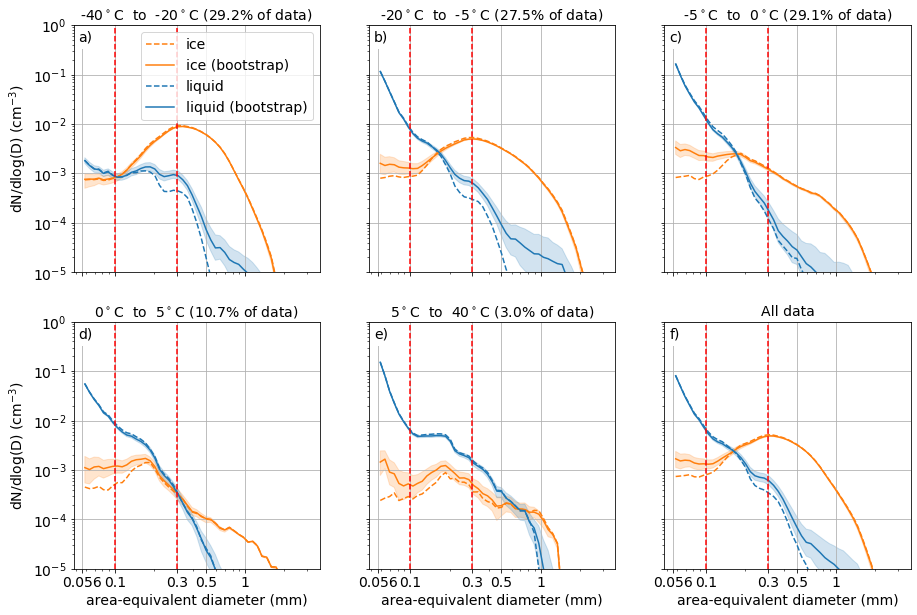

In [11]:
fig, axg = plt.subplots(figsize=(15, 10), nrows=2, ncols=3, sharex=True, sharey=True)
axl = axg.flatten()

all_cloud = psds.count_darea_all.sum(dim='size_bin')>10

temp_ranges = [-40, -20, -5, 0, 5, 40, 100]
for i in range(len(temp_ranges)-1):
    tmin = temp_ranges[i]
    tmax = temp_ranges[i+1]
    if tmax==100:
        tmin = -100
    ax = axl[i]
    idx = np.logical_and(flights.ATX>tmin, flights.ATX<tmax)
    ds = psds.isel(time=idx)
    
    some_particles = ds.count_darea_all.sum(dim='size_bin')>10
    ds = ds.isel(time=some_particles)
    
    bins = np.exp((np.log(ds.bin_edges.values)[1:]+np.log(ds.bin_edges.values)[:-1])/2)
    log_width = np.log(ds.bin_edges.values)[1:]-np.log(ds.bin_edges.values)[:-1]
    
    
    sv = ds.sample_volume.mean(dim='time').values
#     sv = 1
    ice_ml_hist = ds.count_darea_ice_ml.mean(dim='time').values/sv
    liq_ml_hist = ds.count_darea_liq_ml.mean(dim='time').values/sv
#     ice_ar_hist = ds.count_darea_ice_ar.mean(dim='time').values
#     liq_ar_hist = ds.count_darea_liq_ar.mean(dim='time').values
#     ice_ho_hist = ds.count_darea_ice_holroyd.mean(dim='time').values
#     liq_ho_hist = ds.count_darea_liq_holroyd.mean(dim='time').values
    ice_ml_hist_ml = ds.count_darea_ice_ml_median.mean(dim='time').values/sv
    liq_ml_hist_ml = ds.count_darea_liq_ml_median.mean(dim='time').values/sv
    ice_ml_hist_25 = ds.count_darea_ice_ml_25pct.mean(dim='time').values/sv
    liq_ml_hist_25 = ds.count_darea_liq_ml_25pct.mean(dim='time').values/sv
    ice_ml_hist_75 = ds.count_darea_ice_ml_75pct.mean(dim='time').values/sv
    liq_ml_hist_75 = ds.count_darea_liq_ml_75pct.mean(dim='time').values/sv
    
    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.grid('True')
    if i in [0, 3, 6]:
#     if True:
        ax.set_ylabel('dN/dlog(D) (cm$^{-3}$)', fontsize=14)
    if i in [3, 4, 5]:
#     if True:
        ax.set_xlabel('area-equivalent diameter (mm)', fontsize=14)
    ax.plot(bins, ice_ml_hist/log_width, label='ice', c='tab:orange', ls='--')
    ax.plot(bins, ice_ml_hist_ml/log_width, label='ice (bootstrap)', c='tab:orange')
    ax.fill_between(bins, ice_ml_hist_25/log_width, ice_ml_hist_75/log_width, color='tab:orange', alpha=0.2)
#     ax.set_ylim((1e-10, 1e-4))
    ax.set_ylim((1e-5, 1e0))
    ax.plot(bins, liq_ml_hist/log_width, label='liquid', c='tab:blue', ls='--')
    ax.plot(bins, liq_ml_hist_ml/log_width, label='liquid (bootstrap)', c='tab:blue')
    ax.fill_between(bins, liq_ml_hist_25/log_width, liq_ml_hist_75/log_width, color='tab:blue', alpha=0.2)
    if i ==0:
        ax.legend(fontsize=14)
    pct = (np.sum(some_particles)/np.sum(all_cloud)).values.item()
    title=f'{tmin}$^\circ$C  to  {tmax}$^\circ$C ({pct:0.1%} of data)'
    print(f'crossover for {tmin}C-{tmax}C: {bins[np.where(ice_ml_hist>liq_ml_hist)[0][0]]:0.2f} mm')
    if tmax==100:
        title = 'All data'
    ax.set_title(title, fontsize=14)
for ax in axl:
    ticks = [0.056, 0.1, 0.3, 0.5, 1]
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks, fontsize=14)
    ax.tick_params(axis='y', labelsize=14)
    
    for v in [0.1, 0.3]:
        ax.axvline(v, ls='--', c='r')
    
add_labels(axl, shift_data=False)
fig.savefig(r'/home/disk/p/jkcm/plots/particle/size_dist_by_temp.png', bbox_inches='tight')

In [5]:
# #Author: Hans Mohrmann
# import sys
# sys.path.insert(0, os.path.abspath('..'))


# import xarray as xr
# import numpy as np
# import pandas as pd
# import pickle
# import os
# from joblib import dump, load
# import datetime
# import matplotlib.pyplot as plt
# import glob

# from python_scripts.phase_psd import *
# %load_ext autoreload
# %autoreload 2
# print('BOGIES')

BOGIES


In [16]:
psd_files = sorted([i for i in glob.glob('/home/disk/eos9/jkcm/Data/particle/psd/rf*_psd.nc') if not 'rf15' in i])
flight_files = sorted([i for i in glob.glob('/home/disk/eos9/jfinlon/socrates/*/*.PNI.nc') if not 'RF15' in i])

In [19]:
#  cl = xr.open_mfdataset('/home/disk/eos9/jkcm/Data/particle/classified/UW_particle_classifications.*.nc', combine='nested', concat_dim='time')

In [23]:
psds = xr.open_mfdataset(psd_files, combine='by_coords')

In [25]:
ds = []
for f in sorted(flight_files):
    flights = xr.open_dataset(f)
    flights = flights.drop('PSTFC', errors='ignore')
    ds.append(flights)
flights = xr.concat(ds, dim='Time', data_vars=['ATX'], compat="no_conflicts")
flights = flights.rename({'Time': 'time'})

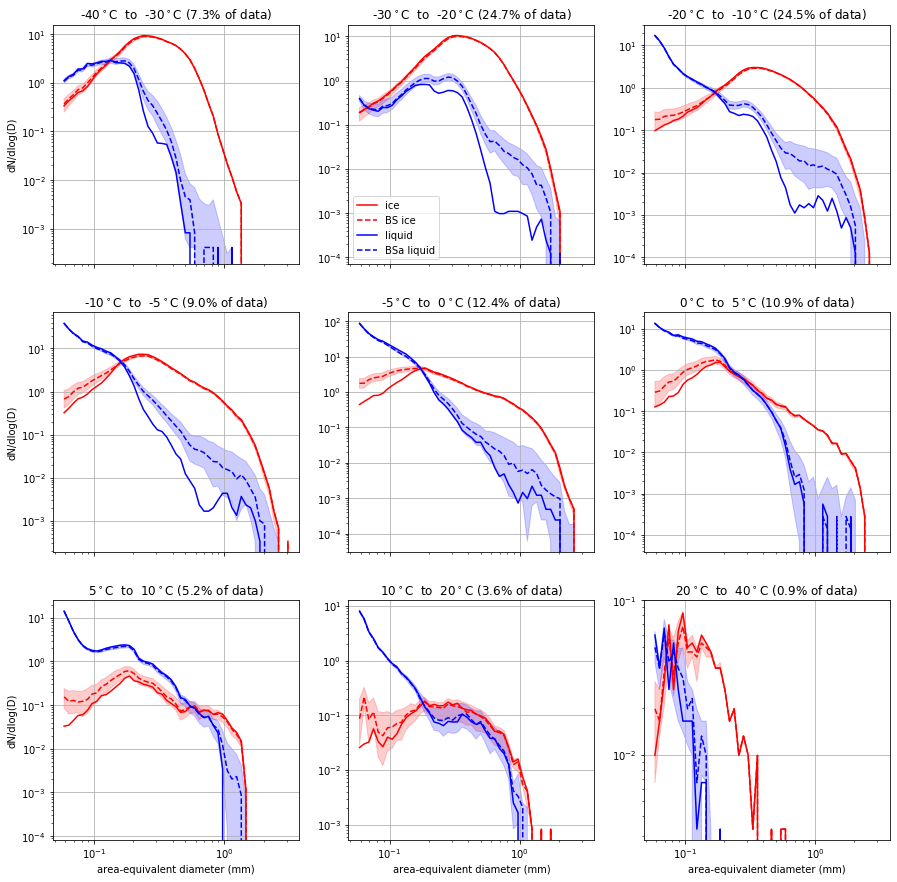

In [7]:
# fig, axg = plt.subplots(figsize=(15, 15), nrows=3, ncols=3, sharex=True, sharey=False)
# axl = axg.flatten()

# temp_ranges = [-40, -30, -20, -10, -5, 0, 5, 10, 20, 40]
# for i in range(len(temp_ranges)-1):
#     tmin = temp_ranges[i]
#     tmax = temp_ranges[i+1]
#     ax = axl[i]
#     idx = np.logical_and(flights.ATX>tmin, flights.ATX<tmax)
#     ds = psds.isel(time=idx)
#     bins = np.exp((np.log(ds.bin_edges.values)[1:]+np.log(ds.bin_edges.values)[:-1])/2)
#     log_width = np.log(ds.bin_edges.values)[1:]-np.log(ds.bin_edges.values)[:-1]
    
    
#     sv = ds.sample_volume.sum(dim='time').values
#     sv = 1
#     ice_ml_hist = ds.count_darea_ice_ml.mean(dim='time').values/sv
#     liq_ml_hist = ds.count_darea_liq_ml.mean(dim='time').values/sv
# #     ice_ar_hist = ds.count_darea_ice_ar.mean(dim='time').values
# #     liq_ar_hist = ds.count_darea_liq_ar.mean(dim='time').values
# #     ice_ho_hist = ds.count_darea_ice_holroyd.mean(dim='time').values
# #     liq_ho_hist = ds.count_darea_liq_holroyd.mean(dim='time').values
#     ice_ml_hist_ml = ds.count_darea_ice_ml_median.mean(dim='time').values/sv
#     liq_ml_hist_ml = ds.count_darea_liq_ml_median.mean(dim='time').values/sv
#     ice_ml_hist_25 = ds.count_darea_ice_ml_25pct.mean(dim='time').values/sv
#     liq_ml_hist_25 = ds.count_darea_liq_ml_25pct.mean(dim='time').values/sv
#     ice_ml_hist_75 = ds.count_darea_ice_ml_75pct.mean(dim='time').values/sv
#     liq_ml_hist_75 = ds.count_darea_liq_ml_75pct.mean(dim='time').values/sv

#     ax.set_xscale('log')
#     ax.set_yscale('log')

#     ax.grid('True')
#     if i in [0, 3, 6]:
# #     if True:
#         ax.set_ylabel('dN/dlog(D)')
#     if i in [6, 7, 8]:
# #     if True:
#         ax.set_xlabel('area-equivalent diameter (mm)')
#     ax.plot(bins, ice_ml_hist/log_width, label='ice', c='r')
#     ax.plot(bins, ice_ml_hist_ml/log_width, label='BS ice', c='r', ls='--')
#     ax.fill_between(bins, ice_ml_hist_25/log_width, ice_ml_hist_75/log_width, color='r', alpha=0.2)
    
#     ax.plot(bins, liq_ml_hist/log_width, label='liquid', c='b')
#     ax.plot(bins, liq_ml_hist_ml/log_width, label='BSa liquid', c='b', ls='--')
#     ax.fill_between(bins, liq_ml_hist_25/log_width, liq_ml_hist_75/log_width, color='b', alpha=0.2)
#     if i ==1:
#         ax.legend()
#     pct = (np.sum(idx)/len(idx)).item()
#     ax.set_title(f'{tmin}$^\circ$C  to  {tmax}$^\circ$C ({pct:0.1%} of data)')

crossover: 0.10 mm
crossover: 0.17 mm
crossover: 0.19 mm
crossover: 0.33 mm
crossover: 0.70 mm
crossover: 0.17 mm


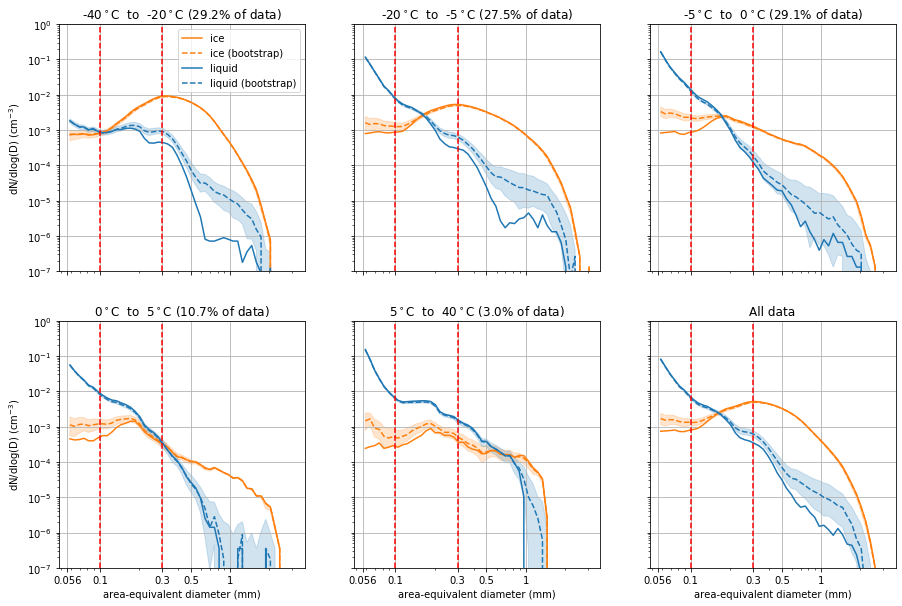

In [36]:
fig, axg = plt.subplots(figsize=(15, 10), nrows=2, ncols=3, sharex=True, sharey=True)
axl = axg.flatten()

all_cloud = psds.count_darea_all.sum(dim='size_bin')>10

temp_ranges = [-40, -20, -5, 0, 5, 40, 100]
for i in range(len(temp_ranges)-1):
    tmin = temp_ranges[i]
    tmax = temp_ranges[i+1]
    if tmax==100:
        tmin = -100
    ax = axl[i]
    idx = np.logical_and(flights.ATX>tmin, flights.ATX<tmax)
    ds = psds.isel(time=idx)
    
    some_particles = ds.count_darea_all.sum(dim='size_bin')>10
    ds = ds.isel(time=some_particles)
    
    bins = np.exp((np.log(ds.bin_edges.values)[1:]+np.log(ds.bin_edges.values)[:-1])/2)
    log_width = np.log(ds.bin_edges.values)[1:]-np.log(ds.bin_edges.values)[:-1]
#     log_width = (ds.bin_edges.values[1:]-ds.bin_edges.values[:-1])/10
    
    
    sv = ds.sample_volume.mean(dim='time').values
#     sv = 1
    ice_ml_hist = ds.count_darea_ice_ml.mean(dim='time').values/sv
    liq_ml_hist = ds.count_darea_liq_ml.mean(dim='time').values/sv
#     ice_ar_hist = ds.count_darea_ice_ar.mean(dim='time').values
#     liq_ar_hist = ds.count_darea_liq_ar.mean(dim='time').values
#     ice_ho_hist = ds.count_darea_ice_holroyd.mean(dim='time').values
#     liq_ho_hist = ds.count_darea_liq_holroyd.mean(dim='time').values
    ice_ml_hist_ml = ds.count_darea_ice_ml_median.mean(dim='time').values/sv
    liq_ml_hist_ml = ds.count_darea_liq_ml_median.mean(dim='time').values/sv
    ice_ml_hist_25 = ds.count_darea_ice_ml_25pct.mean(dim='time').values/sv
    liq_ml_hist_25 = ds.count_darea_liq_ml_25pct.mean(dim='time').values/sv
    ice_ml_hist_75 = ds.count_darea_ice_ml_75pct.mean(dim='time').values/sv
    liq_ml_hist_75 = ds.count_darea_liq_ml_75pct.mean(dim='time').values/sv

    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.grid('True')
    if i in [0, 3, 6]:
#     if True:
        ax.set_ylabel('dN/dlog(D) (cm$^{-3}$)')
    if i in [3, 4, 5]:
#     if True:
        ax.set_xlabel('area-equivalent diameter (mm)')
    ax.plot(bins, ice_ml_hist/log_width, label='ice', c='tab:orange')
    ax.plot(bins, ice_ml_hist_ml/log_width, label='ice (bootstrap)', c='tab:orange', ls='--')
    ax.fill_between(bins, ice_ml_hist_25/log_width, ice_ml_hist_75/log_width, color='tab:orange', alpha=0.2)
#     ax.set_ylim((1e-10, 1e-4))
    ax.set_ylim((1e-7, 1e0))
    ax.plot(bins, liq_ml_hist/log_width, label='liquid', c='tab:blue')
    ax.plot(bins, liq_ml_hist_ml/log_width, label='liquid (bootstrap)', c='tab:blue', ls='--')
    ax.fill_between(bins, liq_ml_hist_25/log_width, liq_ml_hist_75/log_width, color='tab:blue', alpha=0.2)
    if i ==0:
        ax.legend()
    pct = (np.sum(some_particles)/np.sum(all_cloud)).values.item()
    title=f'{tmin}$^\circ$C  to  {tmax}$^\circ$C ({pct:0.1%} of data)'
    print(f'crossover for {tmin}C-{tmax}C: {bins[np.where(ice_ml_hist>liq_ml_hist)[0][0]]:0.2f} mm')
    if tmax==100:
        title = 'All data'
    ax.set_title(title)
for ax in axl:
    ticks = [0.056, 0.1, 0.3, 0.5, 1]
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks)
    
    for v in [0.1, 0.3]:
        ax.axvline(v, ls='--', c='r')
    
# fig.savefig(r'/home/disk/p/jkcm/plots/particle/size_dist_by_temp.png', bbox_inches='tight')

crossover: 0.17 mm


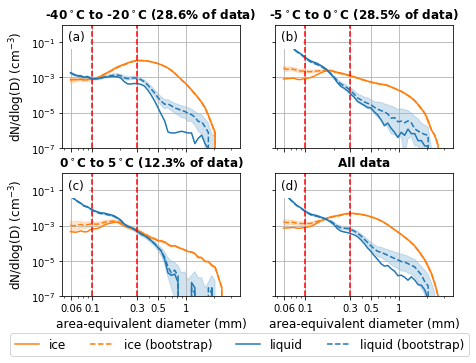

In [54]:
fig, axg = plt.subplots(figsize=(7, 5), nrows=2, ncols=2, sharex=True, sharey=True)
axl = axg.flatten()

all_cloud = psds.count_darea_all.sum(dim='size_bin')>10

# temp_ranges = [-40, -20, -5, 0, 5, 40, 100]
for i, (tmin, tmax) in enumerate([(-40, -20), (-5, 0), (0, 5), (-100, 100)]):
# for i in range(len(temp_ranges)-1):
    # tmin = temp_ranges[i]
    # tmax = temp_ranges[i+1]
    if tmax==100:
        tmin = -100
    ax = axl[i]
    idx = np.logical_and(flights.ATX>tmin, flights.ATX<tmax)
    ds = psds.isel(time=idx)
    
    some_particles = ds.count_darea_all.sum(dim='size_bin')>10
    ds = ds.isel(time=some_particles)
    
    bins = np.exp((np.log(ds.bin_edges.values)[1:]+np.log(ds.bin_edges.values)[:-1])/2)
    log_width = np.log(ds.bin_edges.values)[1:]-np.log(ds.bin_edges.values)[:-1]
#     log_width = (ds.bin_edges.values[1:]-ds.bin_edges.values[:-1])/10
    
    
    sv = ds.sample_volume.mean(dim='time').values
#     sv = 1
    ice_ml_hist = ds.count_darea_ice_ml.mean(dim='time').values/sv
    liq_ml_hist = ds.count_darea_liq_ml.mean(dim='time').values/sv
#     ice_ar_hist = ds.count_darea_ice_ar.mean(dim='time').values
#     liq_ar_hist = ds.count_darea_liq_ar.mean(dim='time').values
#     ice_ho_hist = ds.count_darea_ice_holroyd.mean(dim='time').values
#     liq_ho_hist = ds.count_darea_liq_holroyd.mean(dim='time').values
    ice_ml_hist_ml = ds.count_darea_ice_ml_median.mean(dim='time').values/sv
    liq_ml_hist_ml = ds.count_darea_liq_ml_median.mean(dim='time').values/sv
    ice_ml_hist_25 = ds.count_darea_ice_ml_25pct.mean(dim='time').values/sv
    liq_ml_hist_25 = ds.count_darea_liq_ml_25pct.mean(dim='time').values/sv
    ice_ml_hist_75 = ds.count_darea_ice_ml_75pct.mean(dim='time').values/sv
    liq_ml_hist_75 = ds.count_darea_liq_ml_75pct.mean(dim='time').values/sv

    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.grid('True')
    if i in [0, 2]:
#     if True:
        ax.set_ylabel('dN/dlog(D) (cm$^{-3}$)', fontsize=12)
    if i in [2, 3]:
#     if True:
        ax.set_xlabel('area-equivalent diameter (mm)', fontsize=12)
    ax.plot(bins, ice_ml_hist/log_width, label='ice', c='tab:orange')
    ax.plot(bins, ice_ml_hist_ml/log_width, label='ice (bootstrap)', c='tab:orange', ls='--')
    ax.fill_between(bins, ice_ml_hist_25/log_width, ice_ml_hist_75/log_width, color='tab:orange', alpha=0.2)
#     ax.set_ylim((1e-10, 1e-4))
    ax.set_ylim((1e-7, 1e0))
    ax.plot(bins, liq_ml_hist/log_width, label='liquid', c='tab:blue')
    ax.plot(bins, liq_ml_hist_ml/log_width, label='liquid (bootstrap)', c='tab:blue', ls='--')
    ax.fill_between(bins, liq_ml_hist_25/log_width, liq_ml_hist_75/log_width, color='tab:blue', alpha=0.2)
#     if i ==0:
#         ax.legend()
    pct = (np.sum(some_particles)/np.sum(all_cloud)).values.item()
    title=f'{tmin}$^\circ$C to {tmax}$^\circ$C ({pct:0.1%} of data)'
    if tmax==100:
        title = 'All data'
    ax.set_title(title, fontweight='bold')
    
    
s = 'abcd'
for i, ax in enumerate(axl):
    ax.annotate('({})'.format(s[i]), xy=(0.03, 0.87), xycoords='axes fraction', backgroundcolor='white', fontsize=12)
    ticks = [0.06, 0.1, 0.3, 0.5, 1]
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks)
    for v in [0.1, 0.3]:
        ax.axvline(v, ls='--', c='r')
h,l = axl[0].get_legend_handles_labels()
axl[2].legend(h, l, loc='upper center', ncol=4, bbox_to_anchor=(1, -0.25), fontsize=12)
# plt.tight_layout()
        

fig.savefig(r'/home/disk/p/jkcm/plots/particle/size_dist_by_temp_poster.png', bbox_inches='tight', dpi=300)